In [336]:
from collections import Counter
import ast
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools

plt.style.use('_mpl-gallery')
%matplotlib inline
pd.set_option('display.max_columns', None)

In [337]:
data_path = "./data/listings/"
data = pd.DataFrame()
for file_name in os.listdir(data_path):
    data = pd.concat([data, pd.read_csv(f"{data_path}{file_name}", sep=",")], ignore_index=True)

In [338]:
data.sort_values(by="last_scraped", ascending=False, inplace=True)
data.drop_duplicates(subset=["id"], keep="first", ignore_index=True, inplace=True)

In [462]:
# data.head()

In [339]:
def normalize_amenity(amenity: str) -> str:
    amenity = amenity.lower()
    amenity = amenity.replace("-", " ")
    amenity = re.sub(r"[^\w\s]", " ", amenity)
    amenity = re.sub(r"[\s]{2,}", " ", amenity)
    amenity = amenity.strip()
    return amenity

In [340]:
data["amenities"] = [[normalize_amenity(amenity) for amenity in ast.literal_eval(amenities)] for amenities in data["amenities"]]
amenities = Counter(itertools.chain(*data["amenities"]))

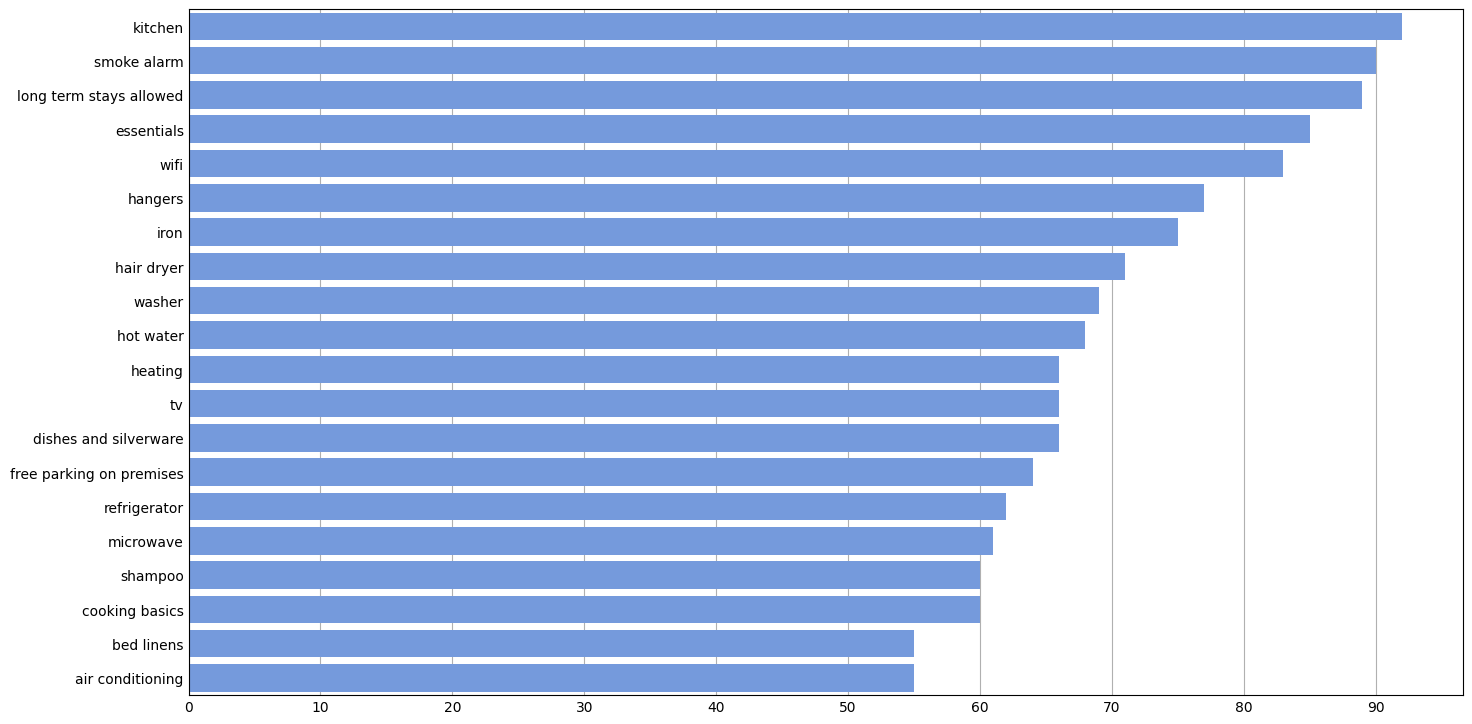

In [342]:
top20_amenities = dict(sorted(amenities.items(), key=lambda x:x[1], reverse=True)[:20])
top20_values_in_percent = [round(value / len(data) * 100) for value in top20_amenities.values()]

plt.figure(figsize=(13, 7))
plt.xticks(range(0,100,10))
sns.barplot(x=top20_values_in_percent, y=list(top20_amenities.keys()), color = "cornflowerblue");

In [343]:
data["amenities_count"] = [len(amenities) for amenities in data["amenities"]]

In [440]:
data["price_amount"] = [price_str[1:].replace(",", "") for price_str in data["price"]]
data["price_amount"] = data["price_amount"].astype("float")

In [451]:
# remove price outlier
data = data[(data["price_amount"] > 10) & (data["price_amount"] < 5000)]

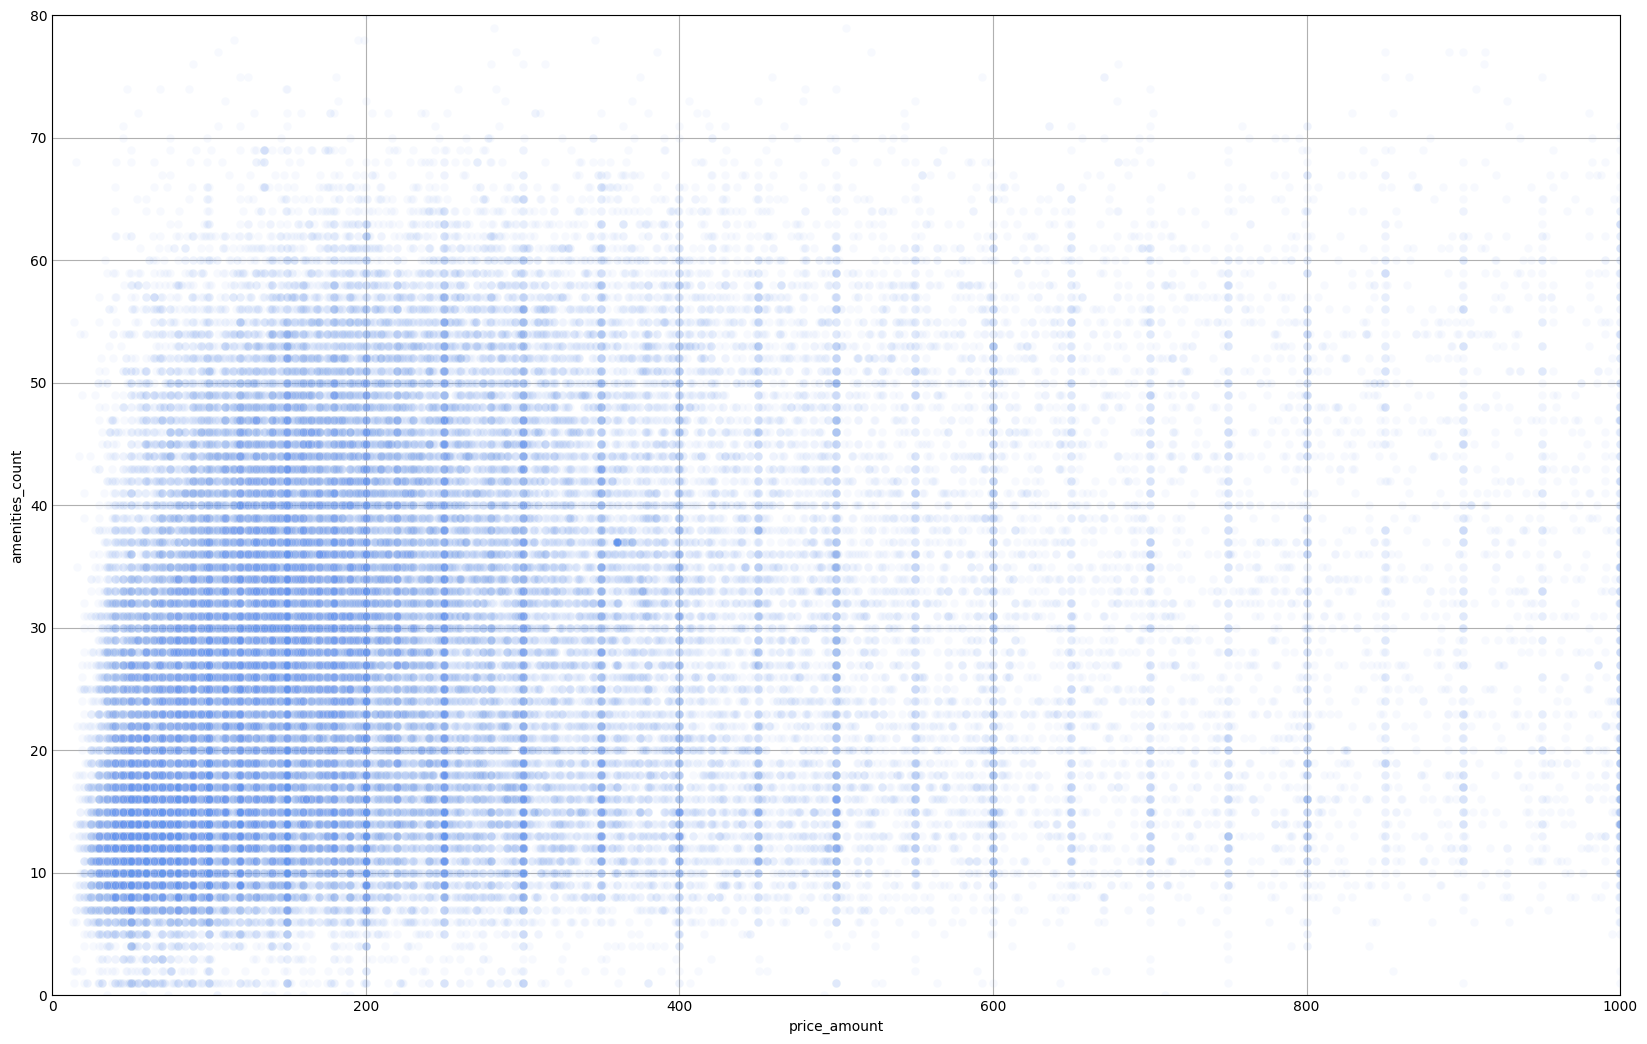

In [461]:
plt.figure(figsize=(16, 10))
plt.xlim(0,1000)
plt.ylim(0,80)
sns.scatterplot(y=data["amenities_count"],
                x=data["price_amount"],
                color = "cornflowerblue",
                alpha=0.05
);

In [470]:
print(f"There is a very weak correlation of {round(data['amenities_count'].corr(data['price_amount']), 3)} between the price and the number of amenities.")

There is a very weak correlation of 0.141 between the price and the number of amenities.


In [423]:
# rating with less than 5 reviews are not meaningful
data["rating_with_min_5_reviews"] = [rating if review_count >= 5 else np.NaN for rating, review_count in zip(data["review_scores_rating"], data["number_of_reviews"])] 
data = data[data["rating_with_min_5_reviews"].notnull()]

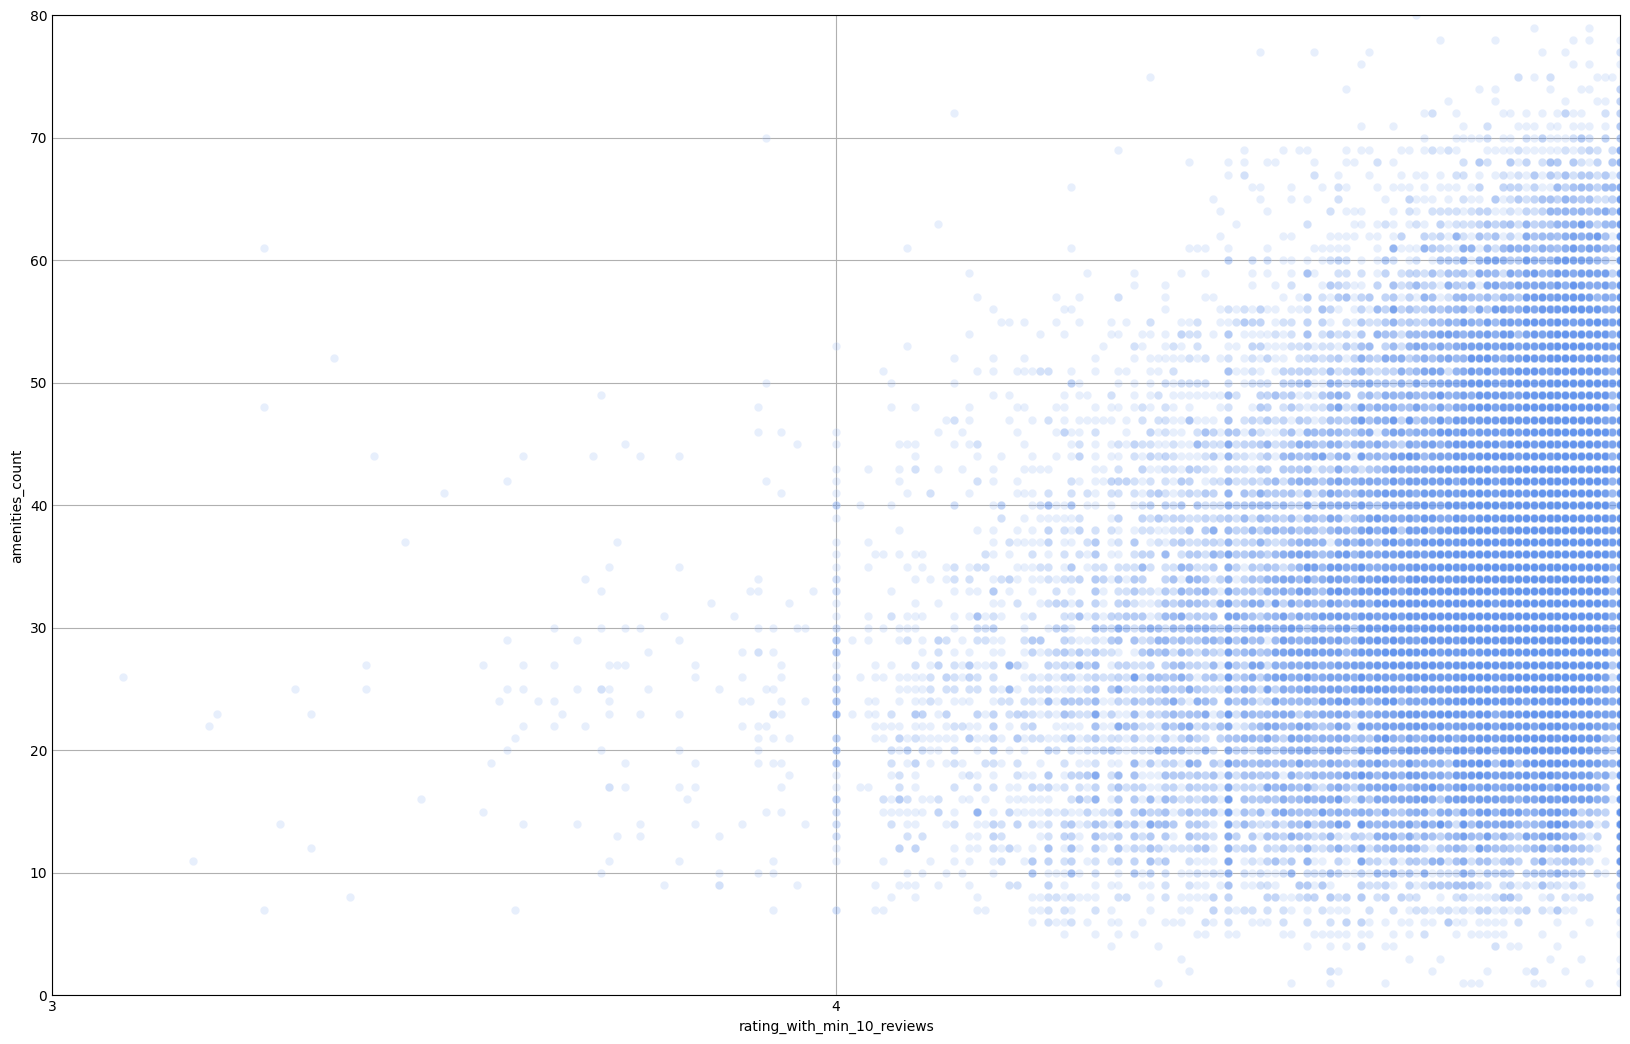

In [428]:
plt.figure(figsize=(16, 10))
plt.xticks(range(3,5,1))
plt.xlim(3,5)
plt.ylim(0,80)
sns.scatterplot(y=data["amenities_count"],
                x=data["rating_with_min_5_reviews"],
                color = "cornflowerblue",
                alpha=0.15
);

In [469]:
print(f"There is a low/moderate correlation of {round(data['amenities_count'].corr(data['rating_with_min_5_reviews']), 3)} between the ratings and the number of amenities.")

There is a low/moderate correlation of 0.26 between the ratings and the number of amenities.


In [350]:
# only use popular/standardized amenity values
MIN_AMENITY_COUNT = 200

origin_amenity_keys = len(amenities.keys())
origin_amenity_values_sum = sum(amenities.values())

amenities = {amenity: amenity_count for (amenity, amenity_count) in amenities.items() if amenity_count >= MIN_AMENITY_COUNT}

print(f"Removed {round(abs(len(amenities.keys()) / origin_amenity_keys - 1) * 100, 1)}% amenity keys "
      f"but only {round(abs(sum(amenities.values()) / origin_amenity_values_sum - 1) * 100, 1)}% of the set amenity values in total.")

Removed 0.0% amenity keys but only 0.0% of the set amenity values in total.


In [347]:
new_amenity_data = pd.concat([pd.Series(name=f"amenity_{amenity.replace("", "_")}",
                              data=[amenity in accomodation_amenities for accomodation_amenities in data["amenities"]]) 
                              for amenity in amenities.keys()], axis=1)
data = pd.concat([data, new_amenity_data], axis=1)

In [ ]:
numeric_rating_prediction_columns = ["host_response_time",
                                     "host_reponse_rate",
                                     "accomodates", ]
categorical_rating_prediction_columns = ["host_is_superhost",
                                         "neighbourhood_cleansed",
                                         "property_type",
                                         "room_type", ]

In [471]:
data.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,amenities_count,amenity_dishwasher,amenity_bbq grill,amenity_hangers,amenity_private entrance,amenity_coffee maker,amenity_microwave,amenity_drying rack for clothing,amenity_room darkening shades,amenity_bed linens,amenity_air conditioning,amenity_wine glasses,amenity_indoor fireplace,amenity_cooking basics,amenity_long term stays allowed,amenity_essentials,amenity_oven,amenity_hot water,amenity_bathtub,amenity_free street parking,amenity_hot water kettle,amenity_wifi,amenity_kitchen,amenity_high chair,amenity_hair dryer,amenity_toaster,amenity_gas stove,amenity_heating,amenity_single level home,amenity_lockbox,amenity_patio or balcony,amenity_washer,amenity_crib,amenity_board games,amenity_tv,amenity_iron,amenity_outdoor dining area,amenity_fireplace guards,amenity_laundromat nearby,amenity_shampoo,amenity_outdoor furniture,amenity_children s dinnerware,amenity_free parking on premises,amenity_smoke alarm,amenity_barbecue utensils,amenity_extra pillows and blankets,amenity_backyard,amenity_refrigerator,amenity_dishes and silverware,amenity_fire pit,amenity_nespresso machine,amenity_shower gel,amenity_clothing storage walk in closet and wardrobe,amenity_shared patio or balcony,amenity_breakfast,amenity_beachfront,amenity_shared pool,amenity_first aid kit,amenity_fire extinguisher,amenity_shared garden or backyard,amenity_host greets you,amenity_cleaning products,amenity_stove,amenity_bikes,amenity_pocket wifi,amenity_private patio or balcony,amenity_dining table,amenity_freezer,amenity_beach essentials,amenity_private hot tub,amenity_ceiling fan,amenity_baking sheet,amenity_game console,amenity_private fenced garden or backyard,amenity_lake access,amenity_children s books and toys,amenity_body soap,amenity_smart lock,amenity_mini fridge,amenity_dedicated workspace,amenity_outdoor shower,amenity_ping pong table,amenity_private garden or backyard,amenity_baby safety gates,amenity_security cameras on property,amenity_ac split type ductless system,amenity_dryer,amenity_sound system,amenity_portable fans,amenity_safe,amenity_elevator,amenity_electric stove,amenity_children s books and toys for ages 0 2 years old 2 5 years old 5 10 years old and 10 years old,amenity_clothing storage wardrobe,amenity_rice maker,amenity_clothing storage,amenity_tv with netflix,amenity_pack n play travel crib,amenity_ethernet connection,amenity_radiant heating,amenity_carbon monoxide alarm,amenity_kayak,amenity_free driveway parking on premises 1 space,amenity_ev charger,amenity_central air conditioning,amenity_conditioner,amenity_clothing storage walk in closet,amenity_central heating,amenity_free washer in building,amenity_pool,amenity_clothing storag